In [128]:
import MDAnalysis as mda
import mdtraj as md
import os
import numpy as np
import netCDF4 as nc

In [129]:
from os import walk
import socket
if socket.gethostname() == 'jim-Mint':
    ppi_path = '/home/jim/src/p39/fftanalysis/test_systems'
    home = '/home/jim'
elif socket.gethostname() == 'host252.ent.iit.edu':
    ppi_path = '/home/jtufts/Downloads/test_systems'
    home = '/home/jtufts'
elif socket.gethostname() == 'pandora':
    # ppi_path = '/home/jtufts/src/p39/fftanalysis/test_systems'
    # ppi_path = '/mnt/elpis/jtufts/fft/FFT_PPI_1_0'
    # ppi_path = '/mnt/elpis/jtufts/fft/FFT_PPI_2_0'
    ppi_path = '/home/jtufts/fft/FFT_PPI'
    home = '/home/jtufts'
else:
    ppi_path = '/home/jtufts/src/p39/fftanalysis/test_systems'
    home = '/home/jtufts'

In [130]:
f = {}
for (dirpath, dirnames, filenames) in walk(f'{ppi_path}/2.redock/2.minimize'):
    if len(filenames) > 0:
        if filenames[0] != 'run_me.sh':
            if 'ligand.inpcrd' in filenames:
                # f[dirpath.split('/')[8]] = dirpath + '/ligand.inpcrd'
                f[dirpath.split('/')[7]] = dirpath + '/ligand.inpcrd'

In [131]:
keys = list(f.keys())
keys.sort()
system_test = keys[127] #36 #8
print(system_test, f[system_test])

2OOB_A:B /home/jtufts/fft/FFT_PPI/2.redock/2.minimize/2OOB_A:B/ligand.inpcrd


In [ ]:
import MDAnalysis as mda
import os
import multiprocessing as mp
import numpy as np

def process_system(args):
    system, ppi_path = args
    try:
        # Check if output file already exists
        output_path = f"{ppi_path}/2.redock/4.receptor_grid/{system}/native_pose.pdb"
        # if os.path.exists(output_path):
        #     return f"Skipping system {system}: native_pose.pdb already exists"

        # Calculate translation vector from receptor structures
        receptor_trans_pdb = f"{ppi_path}/2.redock/4.receptor_grid/{system}/receptor_trans.pdb"
        receptor_prmtop = f"{ppi_path}/2.redock/1.amber/{system}/receptor.prmtop"
        receptor_inpcrd = f"{ppi_path}/2.redock/2.minimize/{system}/receptor.inpcrd"

        # Check if receptor files exist
        for file_path in [receptor_trans_pdb, receptor_prmtop, receptor_inpcrd]:
            if not os.path.exists(file_path):
                return f"Error: Receptor file {file_path} not found for system {system}"

        receptor_trans_universe = mda.Universe(receptor_trans_pdb)
        receptor_original_universe = mda.Universe(receptor_prmtop, receptor_inpcrd)

        # Calculate translation vector
        translation_vector = np.mean(receptor_trans_universe.atoms.positions - receptor_original_universe.atoms.positions, axis=0)

        # Create MDAnalysis Universe for ligand
        ligand_prmtop = f"{ppi_path}/2.redock/1.amber/{system}/ligand.prmtop"
        ligand_inpcrd = f"{ppi_path}/2.redock/2.minimize/{system}/ligand.inpcrd"
        
        if not os.path.exists(ligand_prmtop) or not os.path.exists(ligand_inpcrd):
            return f"Warning: PRMTOP or INPCRD file not found for system {system}"

        ligand_universe = mda.Universe(ligand_prmtop, ligand_inpcrd)

        # Apply translation to ligand coordinates
        ligand_universe.atoms.positions += translation_vector

        # Write output file
        output_dir = os.path.dirname(output_path)
        os.makedirs(output_dir, exist_ok=True)
        ligand_universe.atoms.write(output_path)

        return f"Successfully processed system {system}"
    
    except Exception as e:
        return f"Error processing system {system}: {str(e)}"

def main(keys, ppi_path):
    # Determine the number of processes to use
    num_processes = min(mp.cpu_count(), len(keys))
    
    # Create a pool of worker processes
    with mp.Pool(processes=num_processes) as pool:
        # Map the process_system function to all systems
        results = pool.map(process_system, [(system, ppi_path) for system in keys])
    
    # Print results
    for result in results:
        print(result)

if __name__ == "__main__":
    # Assuming keys and ppi_path are defined elsewhere
    main(keys, ppi_path)

In [ ]:
import os
import numpy as np
import MDAnalysis as mda
import multiprocessing as mp

def process_system(args):
    system, ppi_path = args
    try:
        pdb_file1 = f"{ppi_path}/2.redock/4.receptor_grid/{system}/native_pose.pdb"
        pdb_file2 = f"{ppi_path}/2.redock/4.receptor_grid/{system}/receptor_trans.pdb"
        
        # Check if input files exist
        if not os.path.exists(pdb_file1):
            return f"Error: {pdb_file1} not found for system {system}"
        if not os.path.exists(pdb_file2):
            return f"Error: {pdb_file2} not found for system {system}"
        
        # Check if output file already exists
        output_dir = f"{ppi_path}/2.redock/7.analysis/{system}/dockq"
        output_file = f"{output_dir}/native_complex.pdb"
        # if os.path.exists(output_file):
        #     return f"Skipping system {system}: native_complex.pdb already exists"
        
        # Load the PDB files into MDAnalysis Universes
        u1 = mda.Universe(pdb_file1)
        u1_chainid = np.full(u1.atoms.chainIDs.shape, "L", dtype='U1')
        u1.atoms.chainIDs = u1_chainid

        u2 = mda.Universe(pdb_file2)
        u2_chainid = np.full(u2.atoms.chainIDs.shape, "R", dtype='U1')
        u2.atoms.chainIDs = u2_chainid
        
        combined_universe = mda.Merge(u1.atoms, u2.atoms)
        
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        
        # Save the combined structure to a new PDB file
        combined_universe.atoms.write(output_file)
        
        return f"Successfully processed system {system}"
    
    except Exception as e:
        return f"Error processing system {system}: {str(e)}"

def main(keys, ppi_path):
    # Determine the number of processes to use
    num_processes = min(mp.cpu_count(), len(keys))
    
    # Create a pool of worker processes
    with mp.Pool(processes=num_processes) as pool:
        # Map the process_system function to all systems
        results = pool.map(process_system, [(system, ppi_path) for system in keys])
    
    # Print results
    for result in results:
        print(result)

if __name__ == "__main__":
    # Assuming keys and ppi_path are defined elsewhere
    main(keys, ppi_path)


In [134]:
import os
import numpy as np
import MDAnalysis as mda
import multiprocessing as mp

def process_system(args):
    system, ppi_path = args
    try:
        fft_sampling_nc = f"{ppi_path}/2.redock/5.fft_sampling/{system}/fft_sample.nc"
        pdb_file1 = f"{ppi_path}/2.redock/6.postprocess/{system}/ligand_resampled_nonative.pdb"
        pdb_file2 = f"{ppi_path}/2.redock/4.receptor_grid/{system}/receptor_trans.pdb"
        
        # Check if input files exist
        for file_path in [fft_sampling_nc, pdb_file1, pdb_file2]:
            if not os.path.exists(file_path):
                return f"Error: {file_path} not found for system {system}"
        
        # Load the PDB files into MDAnalysis Universes
        u1 = mda.Universe(pdb_file1)
        u1.atoms.chainIDs = np.full(u1.atoms.chainIDs.shape, "L", dtype='U1')
        
        u2 = mda.Universe(pdb_file2)
        u2.atoms.chainIDs = np.full(u2.atoms.chainIDs.shape, "R", dtype='U1')
        
        output_dir = f"{ppi_path}/2.redock/7.analysis/{system}/dockq"
        os.makedirs(output_dir, exist_ok=True)
        
        for frame in u1.trajectory[:100]:
            output_file = f"{output_dir}/docked_complex_no_native_{u1.trajectory.frame}.pdb"
            
            # Skip if the file already exists
            if os.path.exists(output_file):
                continue
            
            combined_universe = mda.Merge(u1.atoms, u2.atoms)
            combined_universe.atoms.write(output_file)
        
        return f"Successfully processed all frames for system {system}"
    
    except Exception as e:
        return f"Error processing system {system}: {str(e)}"

def main(keys, ppi_path):
    # Determine the number of processes to use
    num_processes = min(mp.cpu_count(), len(keys))
    
    # Create a pool of worker processes
    with mp.Pool(processes=num_processes) as pool:
        # Map the process_system function to all systems
        results = pool.map(process_system, [(system, ppi_path) for system in keys])
    
    # Print results
    for result in results:
        print(result)

if __name__ == "__main__":
    # Assuming keys and ppi_path are defined elsewhere
    main(keys, ppi_path)

/home/jtufts/anaconda3/envs/fft/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/jtufts/anaconda3/envs/fft/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/jtufts/anaconda3/envs/fft/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/jtufts/anaconda3/envs/fft/li

Successfully processed all frames for system 1A2K_C:AB
Successfully processed all frames for system 1ACB_E:I
Error: /home/jtufts/fft/FFT_PPI/2.redock/5.fft_sampling/1AHW_AB:C/fft_sample.nc not found for system 1AHW_AB:C
Successfully processed all frames for system 1AK4_A:D
Successfully processed all frames for system 1AKJ_AB:DE
Successfully processed all frames for system 1ATN_A:D
Successfully processed all frames for system 1AVX_A:B
Successfully processed all frames for system 1AVZ_B:C
Successfully processed all frames for system 1AY7_A:B
Successfully processed all frames for system 1B6C_A:B
Successfully processed all frames for system 1BJ1_HL:VW
Successfully processed all frames for system 1BRS_A:D
Successfully processed all frames for system 1BUH_A:B
Successfully processed all frames for system 1BVK_DE:F
Successfully processed all frames for system 1BVN_P:T
Successfully processed all frames for system 1CBW_ABC:D
Error: /home/jtufts/fft/FFT_PPI/2.redock/5.fft_sampling/1DE4_AB:CF/fft_

In [135]:
import os
import numpy as np
import MDAnalysis as mda
import multiprocessing as mp

def process_system(args):
    system, ppi_path = args
    try:
        fft_sampling_nc = f"{ppi_path}/2.redock/5.fft_sampling/{system}/fft_sample.nc"
        pdb_file1 = f"{ppi_path}/2.redock/6.postprocess/{system}/ligand_resampled.pdb"
        pdb_file2 = f"{ppi_path}/2.redock/4.receptor_grid/{system}/receptor_trans.pdb"
        
        # Check if input files exist
        for file_path in [fft_sampling_nc, pdb_file1, pdb_file2]:
            if not os.path.exists(file_path):
                return f"Error: {file_path} not found for system {system}"
        
        # Load the PDB files into MDAnalysis Universes
        u1 = mda.Universe(pdb_file1)
        u1.atoms.chainIDs = np.full(u1.atoms.chainIDs.shape, "L", dtype='U1')
        
        u2 = mda.Universe(pdb_file2)
        u2.atoms.chainIDs = np.full(u2.atoms.chainIDs.shape, "R", dtype='U1')
        
        output_dir = f"{ppi_path}/2.redock/7.analysis/{system}/dockq"
        os.makedirs(output_dir, exist_ok=True)
        
        for frame in u1.trajectory[:100]:
            output_file = f"{output_dir}/docked_complex_incl_native_{u1.trajectory.frame}.pdb"
            
            # Skip if the file already exists
            if os.path.exists(output_file):
                continue
            
            combined_universe = mda.Merge(u1.atoms, u2.atoms)
            combined_universe.atoms.write(output_file)
        
        return f"Successfully processed all frames for system {system}"
    
    except Exception as e:
        return f"Error processing system {system}: {str(e)}"

def main(keys, ppi_path):
    # Determine the number of processes to use
    num_processes = min(mp.cpu_count(), len(keys))
    
    # Create a pool of worker processes
    with mp.Pool(processes=num_processes) as pool:
        # Map the process_system function to all systems
        results = pool.map(process_system, [(system, ppi_path) for system in keys])
    
    # Print results
    for result in results:
        print(result)

if __name__ == "__main__":
    # Assuming keys and ppi_path are defined elsewhere
    main(keys, ppi_path)

/home/jtufts/anaconda3/envs/fft/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/jtufts/anaconda3/envs/fft/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/jtufts/anaconda3/envs/fft/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/jtufts/anaconda3/envs/fft/li

Successfully processed all frames for system 1A2K_C:AB
Successfully processed all frames for system 1ACB_E:I
Error: /home/jtufts/fft/FFT_PPI/2.redock/5.fft_sampling/1AHW_AB:C/fft_sample.nc not found for system 1AHW_AB:C
Successfully processed all frames for system 1AK4_A:D
Successfully processed all frames for system 1AKJ_AB:DE
Successfully processed all frames for system 1ATN_A:D
Successfully processed all frames for system 1AVX_A:B
Successfully processed all frames for system 1AVZ_B:C
Successfully processed all frames for system 1AY7_A:B
Successfully processed all frames for system 1B6C_A:B
Successfully processed all frames for system 1BJ1_HL:VW
Successfully processed all frames for system 1BRS_A:D
Successfully processed all frames for system 1BUH_A:B
Successfully processed all frames for system 1BVK_DE:F
Successfully processed all frames for system 1BVN_P:T
Successfully processed all frames for system 1CBW_ABC:D
Error: /home/jtufts/fft/FFT_PPI/2.redock/5.fft_sampling/1DE4_AB:CF/fft_

In [136]:
import subprocess
import multiprocessing as mp
import os
import pickle

def run_dockq(args):
    system, ppi_path = args
    system_results = {}
    try:
        for i in range(100):  # This can be changed if you want to process more frames
            native_pdb = f"{ppi_path}/2.redock/7.analysis/{system}/dockq/native_complex.pdb"
            docked_pdb = f"{ppi_path}/2.redock/7.analysis/{system}/dockq/docked_complex_no_native_{i}.pdb"
            
            # Check if input files exist
            if not os.path.exists(native_pdb) or not os.path.exists(docked_pdb):
                return system, f"Error: Input PDB files not found for system {system}"
            
            command = f"/home/jtufts/src/p39/DockQ/DockQ.py {native_pdb} {docked_pdb}"
            output = subprocess.check_output(command, shell=True, universal_newlines=True)
            
            data_dict = {}
            lines = output.strip().split('\n')
            
            for line in lines:
                if "Number of equivalent residues in chain L" in line:
                    data_dict["chain_L"] = int(line.split()[-2])
                elif "Number of equivalent residues in chain R" in line:
                    data_dict["chain_R"] = int(line.split()[-2])
                elif line.startswith("Fnat"):
                    data_dict["Fnat"] = float(line.split()[1])
                elif line.startswith("Fnonnat"):
                    data_dict["Fnonnat"] = float(line.split()[1])
                elif line.startswith("iRMS"):
                    data_dict["iRMSD"] = float(line.split()[1])
                elif line.startswith("LRMS"):
                    data_dict["LRMS"] = float(line.split()[1])
                elif line.startswith("DockQ"):
                    data_dict["DockQ"] = float(line.split()[1])
            
            system_results[i] = data_dict
        
        return system, system_results
    except subprocess.CalledProcessError as e:
        return system, f"Error running DockQ for system {system}: {str(e)}"
    except Exception as e:
        return system, f"Unexpected error processing system {system}: {str(e)}"

def main(keys, ppi_path):
    # Determine the number of processes to use
    num_processes = min(mp.cpu_count(), len(keys))
    
    # Create a pool of worker processes
    with mp.Pool(processes=num_processes) as pool:
        # Map the run_dockq function to all systems
        results = pool.map(run_dockq, [(system, ppi_path) for system in keys])
    
    # Collect results
    dockq_results = {}
    errors = []
    for system, result in results:
        if isinstance(result, dict):
            dockq_results[system] = result
        else:
            errors.append(result)  # Collect error messages
    
    # Print error messages
    if errors:
        print("Errors encountered:")
        for error in errors:
            print(error)
    
    # Save results to a pickle file
    output_dir = os.path.join(ppi_path, "2.redock", "8.analysis_results")
    os.makedirs(output_dir, exist_ok=True)
    pickle_file = os.path.join(output_dir, "dockq_results_no_native.pickle")
    
    with open(pickle_file, 'wb') as f:
        pickle.dump(dockq_results, f)
    
    print(f"Results saved to {pickle_file}")
    
    # Optionally, you can still print the results
    print("DockQ Results:")
    print(dockq_results)

if __name__ == "__main__":
    # Assuming keys and ppi_path are defined elsewhere
    main(keys, ppi_path)

Traceback (most recent call last):
  File "/home/jtufts/src/p39/DockQ/DockQ.py", line 732, in <module>
    main()    
  File "/home/jtufts/src/p39/DockQ/DockQ.py", line 660, in main
    info=calc_DockQ(model,native,use_CA_only=use_CA_only,capri_peptide=capri_peptide) #False):
  File "/home/jtufts/src/p39/DockQ/DockQ.py", line 277, in calc_DockQ
    assert len(ref_atoms)!=0, "length of native is zero"
AssertionError: length of native is zero
Traceback (most recent call last):
  File "/home/jtufts/src/p39/DockQ/DockQ.py", line 732, in <module>
    main()    
  File "/home/jtufts/src/p39/DockQ/DockQ.py", line 660, in main
    info=calc_DockQ(model,native,use_CA_only=use_CA_only,capri_peptide=capri_peptide) #False):
  File "/home/jtufts/src/p39/DockQ/DockQ.py", line 277, in calc_DockQ
    assert len(ref_atoms)!=0, "length of native is zero"
AssertionError: length of native is zero
Traceback (most recent call last):
  File "/home/jtufts/src/p39/DockQ/DockQ.py", line 732, in <module>
    mai

Errors encountered:
Error: Input PDB files not found for system 1AHW_AB:C
Error running DockQ for system 1AY7_A:B: Command '/home/jtufts/src/p39/DockQ/DockQ.py /home/jtufts/fft/FFT_PPI/2.redock/7.analysis/1AY7_A:B/dockq/native_complex.pdb /home/jtufts/fft/FFT_PPI/2.redock/7.analysis/1AY7_A:B/dockq/docked_complex_no_native_0.pdb' returned non-zero exit status 1.
Error running DockQ for system 1BVK_DE:F: Command '/home/jtufts/src/p39/DockQ/DockQ.py /home/jtufts/fft/FFT_PPI/2.redock/7.analysis/1BVK_DE:F/dockq/native_complex.pdb /home/jtufts/fft/FFT_PPI/2.redock/7.analysis/1BVK_DE:F/dockq/docked_complex_no_native_0.pdb' returned non-zero exit status 1.
Error: Input PDB files not found for system 1DE4_AB:CF
Error: Input PDB files not found for system 1E6J_HL:P
Error: Input PDB files not found for system 1F34_A:B
Error: Input PDB files not found for system 1F6M_A:C
Error: Input PDB files not found for system 1GXD_A:C
Error: Input PDB files not found for system 1I4D_D:AB
Error: Input PDB file

In [153]:
from collections import Counter
import matplotlib.pyplot as plt

output_dir = os.path.join(ppi_path, "2.redock", "8.analysis_results")
os.makedirs(output_dir, exist_ok=True)
pickle_file = os.path.join(output_dir, "dockq_results_no_native.pickle")
# pickle_file = os.path.join("/mnt/elpis/jtufts/fft/FFT_PPI_2_0/2.redock/8.analysis_results", "dockq_results_no_native.pickle")

dockq_results = pickle.load(open(pickle_file, "rb"))

def categorize_dockq_score(score):
    if score >= 0.80:
        return "High quality"
    elif score >= 0.49:
        return "Medium quality"
    elif score >= 0.23:
        return "Acceptable quality"
    else:
        return "Incorrect"

def analyze_dockq_scores(dockq_results):
    best_dockq_scores = {}
    for system, frames in dockq_results.items():
        best_score = max((data["DockQ"] for frame, data in frames.items() if "DockQ" in data), default=None)
        if best_score is not None and best_score > 0:
            best_dockq_scores[system] = best_score
    
    if best_dockq_scores:
        # Sort scores in descending order
        sorted_scores = sorted(best_dockq_scores.items(), key=lambda x: x[1], reverse=True)
        
        # Categorize scores
        categorized_scores = [(system, score, categorize_dockq_score(score)) for system, score in sorted_scores]
        
        # Count occurrences of each category
        category_counts = Counter(category for _, _, category in categorized_scores)
        
        return sorted_scores[0][1], categorized_scores, category_counts
    else:
        return None, None, None

def plot_dockq_histogram(categorized_scores):
    scores = [score for _, score, _ in categorized_scores if score > 0]
    categories = [cat for _, score, cat in categorized_scores if score > 0]
    
    plt.figure(figsize=(12, 6))
    
    # Define colors for each category
    color_map = {
        "High quality": "#1a9850",
        "Medium quality": "#91cf60",
        "Acceptable quality": "#d9ef8b",
        "Incorrect": "#fee08b"
    }
    
    # Create the histogram
    n, bins, patches = plt.hist(scores, bins=20, edgecolor='black')
    
    # Color the bars based on the category
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    for count, center, patch in zip(n, bin_centers, patches):
        category = categorize_dockq_score(center)
        patch.set_facecolor(color_map[category])
    
    plt.title("0.5A - Excluding Native Rotation, DockQ Scores")
    plt.xlabel("DockQ Score")
    plt.ylabel("Number of Systems")
    
    # Add a legend
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, edgecolor='black') for color in color_map.values()]
    plt.legend(legend_elements, color_map.keys(), loc="upper right")
    
    # Add vertical lines for category boundaries
    plt.axvline(x=0.23, color='black', linestyle='--', alpha=0.5)
    plt.axvline(x=0.49, color='black', linestyle='--', alpha=0.5)
    plt.axvline(x=0.80, color='black', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig("best_dockq_score_histogram_0_5A_nonative.png")
    plt.close()




max_score, categorized_scores, category_counts = analyze_dockq_scores(dockq_results)
    
if max_score is not None:
    print("\nNon-Zero Best DockQ Score Analysis:")
    print(f"Maximum DockQ score: {max_score:.4f}")
    
    print("\nCategory Distribution (excluding zero scores):")
    for category, count in category_counts.items():
        print(f"{category}: {count}")
    
    non_zero_scores = [(system, score, category) for system, score, category in categorized_scores if score > 0]
    
    print(f"\nTop 10 Ranked Systems (out of {len(non_zero_scores)} non-zero scores):")
    for i, (system, score, category) in enumerate(non_zero_scores[:10], 1):
        print(f"{i}. System: {system}, Best DockQ: {score:.4f}, Quality: {category}")
    
    print(f"\nBottom 10 Ranked Systems (out of {len(non_zero_scores)} non-zero scores):")
    for i, (system, score, category) in enumerate(non_zero_scores[-10:], len(non_zero_scores) - 9):
        print(f"{i}. System: {system}, Best DockQ: {score:.4f}, Quality: {category}")
    
    # Create and save the histogram
    plot_dockq_histogram(non_zero_scores)
    print("\nHistogram of non-zero best DockQ scores has been saved.")
    
    # Print the number of zero scores
    zero_scores_count = len(categorized_scores) - len(non_zero_scores)
    print(f"\nNumber of systems with zero scores: {zero_scores_count}")
else:
    print("\nNo valid non-zero DockQ scores found for analysis.")







Non-Zero Best DockQ Score Analysis:
Maximum DockQ score: 0.8620

Category Distribution (excluding zero scores):
High quality: 3
Medium quality: 65
Acceptable quality: 40
Incorrect: 41

Top 10 Ranked Systems (out of 149 non-zero scores):
1. System: 2OOB_A:B, Best DockQ: 0.8620, Quality: High quality
2. System: 1LFD_B:A, Best DockQ: 0.8580, Quality: High quality
3. System: 3RVW_CD:A, Best DockQ: 0.8170, Quality: High quality
4. System: 3SZK_DE:F, Best DockQ: 0.7900, Quality: Medium quality
5. System: 3H2V_A:E, Best DockQ: 0.7880, Quality: Medium quality
6. System: 1J2J_A:B, Best DockQ: 0.7870, Quality: Medium quality
7. System: 3BP8_AB:C, Best DockQ: 0.7810, Quality: Medium quality
8. System: 1EMV_A:B, Best DockQ: 0.7800, Quality: Medium quality
9. System: 1QA9_A:B, Best DockQ: 0.7790, Quality: Medium quality
10. System: 2PCB_A:B, Best DockQ: 0.7780, Quality: Medium quality

Bottom 10 Ranked Systems (out of 149 non-zero scores):
140. System: 1PVH_A:B, Best DockQ: 0.0120, Quality: Incorr

In [155]:
import subprocess
import multiprocessing as mp
import os
import pickle

def run_dockq(args):
    system, ppi_path = args
    system_results = {}
    try:
        for i in range(100):  # This can be changed if you want to process more frames
            native_pdb = f"{ppi_path}/2.redock/7.analysis/{system}/dockq/native_complex.pdb"
            docked_pdb = f"{ppi_path}/2.redock/7.analysis/{system}/dockq/docked_complex_incl_native_{i}.pdb"
            
            # Check if input files exist
            if not os.path.exists(native_pdb) or not os.path.exists(docked_pdb):
                return system, f"Error: Input PDB files not found for system {system}"
            
            command = f"/home/jtufts/src/p39/DockQ/DockQ.py {native_pdb} {docked_pdb}"
            output = subprocess.check_output(command, shell=True, universal_newlines=True)
            
            data_dict = {}
            lines = output.strip().split('\n')
            
            for line in lines:
                if "Number of equivalent residues in chain L" in line:
                    data_dict["chain_L"] = int(line.split()[-2])
                elif "Number of equivalent residues in chain R" in line:
                    data_dict["chain_R"] = int(line.split()[-2])
                elif line.startswith("Fnat"):
                    data_dict["Fnat"] = float(line.split()[1])
                elif line.startswith("Fnonnat"):
                    data_dict["Fnonnat"] = float(line.split()[1])
                elif line.startswith("iRMS"):
                    data_dict["iRMSD"] = float(line.split()[1])
                elif line.startswith("LRMS"):
                    data_dict["LRMS"] = float(line.split()[1])
                elif line.startswith("DockQ"):
                    data_dict["DockQ"] = float(line.split()[1])
            
            system_results[i] = data_dict
        
        return system, system_results
    except subprocess.CalledProcessError as e:
        return system, f"Error running DockQ for system {system}: {str(e)}"
    except Exception as e:
        return system, f"Unexpected error processing system {system}: {str(e)}"

def main(keys, ppi_path):
    # Determine the number of processes to use
    num_processes = min(mp.cpu_count(), len(keys))
    
    # Create a pool of worker processes
    with mp.Pool(processes=num_processes) as pool:
        # Map the run_dockq function to all systems
        results = pool.map(run_dockq, [(system, ppi_path) for system in keys])
    
    # Collect results
    dockq_results = {}
    errors = []
    for system, result in results:
        if isinstance(result, dict):
            dockq_results[system] = result
        else:
            errors.append(result)  # Collect error messages
    
    # Print error messages
    if errors:
        print("Errors encountered:")
        for error in errors:
            print(error)
    
    # Save results to a pickle file
    output_dir = os.path.join(ppi_path, "2.redock", "8.analysis_results")
    os.makedirs(output_dir, exist_ok=True)
    pickle_file = os.path.join(output_dir, "dockq_results_incl_native.pickle")
    
    with open(pickle_file, 'wb') as f:
        pickle.dump(dockq_results, f)
    
    print(f"Results saved to {pickle_file}")
    
    # Optionally, you can still print the results
    print("DockQ Results:")
    print(dockq_results)

if __name__ == "__main__":
    # Assuming keys and ppi_path are defined elsewhere
    main(keys, ppi_path)

Traceback (most recent call last):
  File "/home/jtufts/src/p39/DockQ/DockQ.py", line 732, in <module>
    main()    
  File "/home/jtufts/src/p39/DockQ/DockQ.py", line 660, in main
    info=calc_DockQ(model,native,use_CA_only=use_CA_only,capri_peptide=capri_peptide) #False):
  File "/home/jtufts/src/p39/DockQ/DockQ.py", line 277, in calc_DockQ
    assert len(ref_atoms)!=0, "length of native is zero"
AssertionError: length of native is zero
Traceback (most recent call last):
  File "/home/jtufts/src/p39/DockQ/DockQ.py", line 732, in <module>
    main()    
  File "/home/jtufts/src/p39/DockQ/DockQ.py", line 660, in main
    info=calc_DockQ(model,native,use_CA_only=use_CA_only,capri_peptide=capri_peptide) #False):
  File "/home/jtufts/src/p39/DockQ/DockQ.py", line 277, in calc_DockQ
    assert len(ref_atoms)!=0, "length of native is zero"
AssertionError: length of native is zero
Traceback (most recent call last):
  File "/home/jtufts/src/p39/DockQ/DockQ.py", line 732, in <module>
    mai

Errors encountered:
Error: Input PDB files not found for system 1AHW_AB:C
Error running DockQ for system 1AY7_A:B: Command '/home/jtufts/src/p39/DockQ/DockQ.py /home/jtufts/fft/FFT_PPI/2.redock/7.analysis/1AY7_A:B/dockq/native_complex.pdb /home/jtufts/fft/FFT_PPI/2.redock/7.analysis/1AY7_A:B/dockq/docked_complex_incl_native_0.pdb' returned non-zero exit status 1.
Error running DockQ for system 1BVK_DE:F: Command '/home/jtufts/src/p39/DockQ/DockQ.py /home/jtufts/fft/FFT_PPI/2.redock/7.analysis/1BVK_DE:F/dockq/native_complex.pdb /home/jtufts/fft/FFT_PPI/2.redock/7.analysis/1BVK_DE:F/dockq/docked_complex_incl_native_0.pdb' returned non-zero exit status 1.
Error: Input PDB files not found for system 1DE4_AB:CF
Error: Input PDB files not found for system 1E6J_HL:P
Error: Input PDB files not found for system 1F34_A:B
Error running DockQ for system 1F6M_A:C: Command '/home/jtufts/src/p39/DockQ/DockQ.py /home/jtufts/fft/FFT_PPI/2.redock/7.analysis/1F6M_A:C/dockq/native_complex.pdb /home/jtufts

In [156]:
from collections import Counter
import matplotlib.pyplot as plt

output_dir = os.path.join(ppi_path, "2.redock", "8.analysis_results")
os.makedirs(output_dir, exist_ok=True)
pickle_file = os.path.join(output_dir, "dockq_results_incl_native.pickle")
# pickle_file = os.path.join("/mnt/elpis/jtufts/fft/FFT_PPI_2_0/2.redock/8.analysis_results", "dockq_results_no_native.pickle")

dockq_results = pickle.load(open(pickle_file, "rb"))

def categorize_dockq_score(score):
    if score >= 0.80:
        return "High quality"
    elif score >= 0.49:
        return "Medium quality"
    elif score >= 0.23:
        return "Acceptable quality"
    else:
        return "Incorrect"

def analyze_dockq_scores(dockq_results):
    best_dockq_scores = {}
    for system, frames in dockq_results.items():
        best_score = max((data["DockQ"] for frame, data in frames.items() if "DockQ" in data), default=None)
        if best_score is not None and best_score > 0:
            best_dockq_scores[system] = best_score
    
    if best_dockq_scores:
        # Sort scores in descending order
        sorted_scores = sorted(best_dockq_scores.items(), key=lambda x: x[1], reverse=True)
        
        # Categorize scores
        categorized_scores = [(system, score, categorize_dockq_score(score)) for system, score in sorted_scores]
        
        # Count occurrences of each category
        category_counts = Counter(category for _, _, category in categorized_scores)
        
        return sorted_scores[0][1], categorized_scores, category_counts
    else:
        return None, None, None

def plot_dockq_histogram(categorized_scores):
    scores = [score for _, score, _ in categorized_scores if score > 0]
    categories = [cat for _, score, cat in categorized_scores if score > 0]
    
    plt.figure(figsize=(12, 6))
    
    # Define colors for each category
    color_map = {
        "High quality": "#1a9850",
        "Medium quality": "#91cf60",
        "Acceptable quality": "#d9ef8b",
        "Incorrect": "#fee08b"
    }
    
    # Create the histogram
    n, bins, patches = plt.hist(scores, bins=20, edgecolor='black')
    
    # Color the bars based on the category
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    for count, center, patch in zip(n, bin_centers, patches):
        category = categorize_dockq_score(center)
        patch.set_facecolor(color_map[category])
    
    plt.title("0.5A - Including Native Rotation, DockQ Scores")
    plt.xlabel("DockQ Score")
    plt.ylabel("Number of Systems")
    
    # Add a legend
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, edgecolor='black') for color in color_map.values()]
    plt.legend(legend_elements, color_map.keys(), loc="upper right")
    
    # Add vertical lines for category boundaries
    plt.axvline(x=0.23, color='black', linestyle='--', alpha=0.5)
    plt.axvline(x=0.49, color='black', linestyle='--', alpha=0.5)
    plt.axvline(x=0.80, color='black', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig("best_dockq_score_histogram_0_5A_inclnative.png")
    plt.close()




max_score, categorized_scores, category_counts = analyze_dockq_scores(dockq_results)
    
if max_score is not None:
    print("\nNon-Zero Best DockQ Score Analysis:")
    print(f"Maximum DockQ score: {max_score:.4f}")
    
    print("\nCategory Distribution (excluding zero scores):")
    for category, count in category_counts.items():
        print(f"{category}: {count}")
    
    non_zero_scores = [(system, score, category) for system, score, category in categorized_scores if score > 0]
    
    print(f"\nTop 10 Ranked Systems (out of {len(non_zero_scores)} non-zero scores):")
    for i, (system, score, category) in enumerate(non_zero_scores[:10], 1):
        print(f"{i}. System: {system}, Best DockQ: {score:.4f}, Quality: {category}")
    
    print(f"\nBottom 10 Ranked Systems (out of {len(non_zero_scores)} non-zero scores):")
    for i, (system, score, category) in enumerate(non_zero_scores[-10:], len(non_zero_scores) - 9):
        print(f"{i}. System: {system}, Best DockQ: {score:.4f}, Quality: {category}")
    
    # Create and save the histogram
    plot_dockq_histogram(non_zero_scores)
    print("\nHistogram of non-zero best DockQ scores has been saved.")
    
    # Print the number of zero scores
    zero_scores_count = len(categorized_scores) - len(non_zero_scores)
    print(f"\nNumber of systems with zero scores: {zero_scores_count}")
else:
    print("\nNo valid non-zero DockQ scores found for analysis.")


Non-Zero Best DockQ Score Analysis:
Maximum DockQ score: 0.8920

Category Distribution (excluding zero scores):
High quality: 17
Medium quality: 57
Acceptable quality: 42
Incorrect: 39

Top 10 Ranked Systems (out of 155 non-zero scores):
1. System: 1HE8_B:A, Best DockQ: 0.8920, Quality: High quality
2. System: 1LFD_B:A, Best DockQ: 0.8840, Quality: High quality
3. System: 3K75_D:B, Best DockQ: 0.8790, Quality: High quality
4. System: 1ZLI_A:B, Best DockQ: 0.8730, Quality: High quality
5. System: 1WEJ_HL:F, Best DockQ: 0.8720, Quality: High quality
6. System: 1QA9_A:B, Best DockQ: 0.8700, Quality: High quality
7. System: 2OOB_A:B, Best DockQ: 0.8620, Quality: High quality
8. System: 1KAC_A:B, Best DockQ: 0.8530, Quality: High quality
9. System: 1BUH_A:B, Best DockQ: 0.8470, Quality: High quality
10. System: 3SZK_DE:F, Best DockQ: 0.8430, Quality: High quality

Bottom 10 Ranked Systems (out of 155 non-zero scores):
146. System: 1PVH_A:B, Best DockQ: 0.0120, Quality: Incorrect
147. Syste

In [157]:
pickle_file

'/home/jtufts/fft/FFT_PPI/2.redock/8.analysis_results/dockq_results_incl_native.pickle'

In [ ]:
import numpy as np
dockq_keys = list(dockq_results.keys())
all_scores = []
for dockq_key in dockq_keys:
    system_max = 0.0
    system_scores = []
    for i in range(100):
        if i in dockq_results[dockq_key].keys():
            if dockq_results[dockq_key][i]["DockQ"] > system_max:
                system_max = dockq_results[dockq_key][i]["DockQ"]
            system_scores.append(dockq_results[dockq_key][i]["DockQ"])
        else:
            system_scores.append(0)
    all_scores.append(system_scores)
system_max_scores = []
for system_score_list in all_scores:
    if len(system_score_list) > 0:
        system_max_scores.append(np.max(system_score_list))
print(np.mean(all_scores), np.mean(system_max_scores))
print(all_scores)
            

In [16]:
count = 0
for s in all_scores:
    print(np.array(s[1:]).max())
    if np.array(s[1:]).max() > 0.8:
        count += 1
print(count/179)

0.088
0.988
0.989
0.994
0.981
0.992
0.988
0.986
0.991
0.988
0.007
0.991
0.985
0.992
0.984
0.993
0.987
0.985
0.99
0.991
0.988
0.99
0.991
0.987
0.983
0.992
0.991
0.988
0.988
0.987
0.986
0.992
0.994
0.989
0.991
0.993
0.993
0.988
0.018
0.988
0.991
0.989
0.99
0.993
0.988
0.992
0.988
0.991
0.991
0.981
0.986
0.992
0.987
0.993
0.987
0.985
0.986
0.984
0.99
0.99
0.99
0.992
0.991
0.99
0.993
0
0.987
0.992
0.99
0.992
0.991
0.993
0.99
0.989
0.986
0.993
0.991
0.981
0.989
0.991
0.007
0.992
0.993
0.993
0.992
0.992
0.987
0.99
0.992
0.992
0.98
0.991
0.99
0.989
0.987
0.987
0.993
0.989
0.985
0.983
0.992
0.985
0.987
0.991
0.987
0.991
0.991
0.98
0.991
0.992
0.99
0.994
0.988
0.988
0.01
0.987
0.987
0.983
0.654
0.986
0.986
0.985
0.992
0.992
0.991
0.982
0.991
0.99
0.991
0.985
0.983
0.993
0.992
0.983
0.994
0.982
0.993
0.985
0.993
0.987
0.981
0.99
0.994
0.991
0.986
0.008
0.992
0.989
0.991
0.988
0.992
0.99
0.991
0.99
0.988
0.993
0.986
0.991
0.991
0.119
0.99
0.99
0.991
0.99
0.984
0.993
0.992
0.987
0.993
0.991
0.987


In [212]:
import pickle as p
p.dump(all_scores, open("top_100_all_scores_with_native.p", "wb"))
p.dump(dockq_results, open("top_100_dockq_results_with_native.p", "wb"))

In [28]:
import pickle as p
all_scores_without_native = p.load(open("top_100_all_scores_without_native.p", "rb"))
all_scores_with_native = p.load(open("top_100_all_scores_with_native.p", "rb"))

In [45]:
count1 = 0
for val in all_scores_without_native:
    if np.max(val)>0.23:
        count1 += 1
print(count1/179)

count2 = 0
for val in all_scores_with_native:
    if np.max(val)>0.23:
        count2 += 1
print(count2/179)

0.7150837988826816
0.9608938547486033


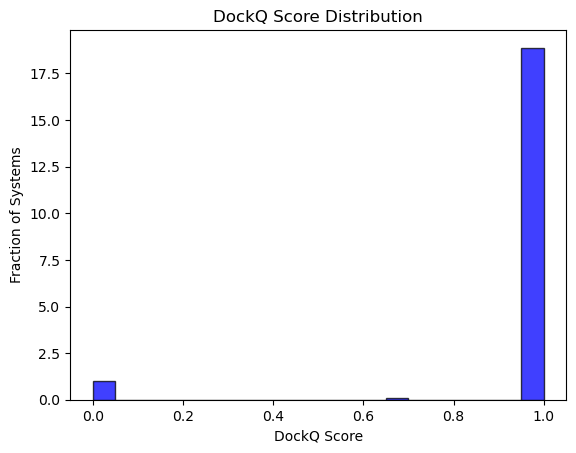

In [58]:
import matplotlib.pyplot as plt

def plot_dockq_histogram(dockq_scores):
    # Create a histogram
    plt.hist(dockq_scores, bins=20, density=True, alpha=0.75, color='blue', edgecolor='black')

    # Set labels and title
    plt.xlabel('DockQ Score')
    plt.ylabel('Fraction of Systems')
    plt.title('DockQ Score Distribution')

    # Display the plot
    plt.show()

if __name__ == "__main__":
    # Example data (replace this with your actual DockQ scores)
    # dockq_scores = [0.2, 0.5, 0.7, 0.8, 0.6, 0.4, 0.9, 0.3, 0.1, 0.5, 0.7]

    # Call the function to plot the histogram
    plot_dockq_histogram(np.array(all_scores_with_native)[:,0])


In [221]:
test = f"{ppi_path}/2.redock/expanse_6.postprocess/2OOB_A:B/bpmf.pkl"
test2 = p.load(open(test, "rb"))


In [233]:
test3 = np.argsort(test2["energies"]["inter_energies"]["OpenMM_OBC2"] - test2["energies"]["delta_E"]["OpenMM_OBC2"])[:100]
# test3 = np.argsort(test2["energies"]["delta_E"]["OpenMM_OBC2"])[:10]
print(test3, (test2["energies"]["inter_energies"]["OpenMM_OBC2"] - test2["energies"]["delta_E"]["OpenMM_OBC2"])[:100])

[  0   4   5  22   1   2   7  19   3  25   9   6   8  28  61  10  16  95
  11  77  48  12  13  38  15  14  53  18  83  17  20  40  23  26  30  44
  24  27 834  66  42  31  29  32  36  46  33  39  52  37  35  21  58  41
 783 124  43  57  92  45  49  47 103  75  50  51  81 221  54 356  74  55
  63  59  69  56 117 108  65  70  71  60  78  93  62  67  72  64 170  76
  94 100  89  73 510  79  97 393 122 145] [678.58536613 701.92950451 709.20657565 719.77511054 687.36182481
 690.80360077 733.6929934  714.3872117  736.65302342 725.01082995
 741.79631483 749.9309124  754.42253973 756.34112094 760.36874104
 758.93470662 748.1276328  764.48598829 761.51848933 715.26014281
 766.81862826 791.84607657 700.81103236 773.72318654 776.65987617
 720.33668066 775.68611451 778.67321941 739.57897646 783.45053328
 776.02081591 783.35810528 786.84796248 787.66907789 838.13429882
 790.5012025  786.87410373 790.41250896 758.10192101 788.05232732
 772.45160134 792.92953812 782.82874492 795.8928358  776.57351667

In [ ]:
for f1 in test3:
        u1.trajectory[f1
        combined_universe = mda.Merge(u1.atoms,u2.atoms)
        if not os.path.exists(f"{ppi_path}/2.redock/7.analysis/{system}/dockq"):
            os.mkdir(f"{ppi_path}/2.redock/7.analysis/{system}/dockq")
        # Save the combined structure to a new PDB file
        combined_universe.atoms.write(f"{ppi_path}/2.redock/7.analysis/{system}/dockq/docked_complex_no_native_{u1.trajectory.frame}.pdb")

In [ ]:
test2["energies"]["delta_E"]["OpenMM_OBC2"]

In [175]:
a = p.load(open("all_scores_without_native.p", "rb"))
b = p.load(open("dockq_results_without_native.p", "rb"))



In [235]:
test2["energies"].keys()

dict_keys(['lig_desol_fe', 'rec_desol_fe', 'complex_sol_fe', 'delta_E', 'lse', 'inter_energies'])

In [239]:
print(np.argsort(test2["energies"]["lse"]["OpenMM_OBC2"])[:100])

[ 22  25   4  95   5   9   0  61  19 834  21   2   7   1  28  38   6   3
  34  83  40  77  48  16  53 783   8  10  66  11  15  12 122  30 170  18
 510  17  13 356  44  14  27 124 108  20 103  42  31  26  81  23 221  24
 393  39  29  58  52  92  33  46  93  41  49  36 157  57  32  65  75  37
  35  45 530  43  51 207  47 553 145  97 217  50  72 241 118  69 100 186
  59 371 159 818  63 189  54  56 177  62]
